In [3]:
import os
import re
import json
import gc
import logging
import unicodedata
import random
from pathlib import Path
from types import SimpleNamespace
from collections import Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# 1) Your FinalSamplesDataset (verbatim)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0); y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1]); y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if not pth or not os.path.exists(pth): return pad17([])+pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side=='left': left=lst
                        else:            right=lst

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left =[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        return re.sub(r'\s+',' ', text).strip()

# prepare_data function for binary balancing
def count_labels(data, target_classes, cfg):
    from collections import defaultdict
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl]+=1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, cfg, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes, cfg)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    # pad the patch sequences
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    # gather inputs
    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    # build shifted labels without in-place assignment
    labels = []
    for i in ids:
        seq = i.tolist()            # full list of token IDs, e.g. [BOS, ..., EOS]
        shifted = seq[1:] + [-100]  # drop the first, pad last with -100
        labels.append(torch.tensor(shifted, dtype=torch.long))

    # pad them all
    input_ids = nn.utils.rnn.pad_sequence(ids,    batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels



# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
    def forward(self,x):
        b,t,c = x.size()
        q,k,v = self.c_attn(x).chunk(3,-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        att = (q@k.transpose(-2,-1))*self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att,-1); att = self.attn_dropout(att)
        y = att@v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.q= nn.Linear(self.embed_dim,self.embed_dim)
        self.k= nn.Linear(self.embed_dim,self.embed_dim)
        self.v= nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size**-0.5
        self.c_proj= nn.Linear(self.embed_dim,self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,0,0.02)
            nn.init.zeros_(m.bias)
    def forward(self, q,k,v):
        b,qt,_=q.size()
        q_ = self.q(q).view(b,qt,self.n_heads,self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        att = F.softmax((q_@k_.transpose(-2,-1))*self.scale, -1)
        att = self.attn_dropout(att)
        y = att@v_; y = y.permute(0,2,1,3).contiguous().view(b,qt,self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc=nn.Linear(config.embed_dim, config.embed_dim*config.mlp_ratio)
        self.act=nn.GELU()
        self.c_proj=nn.Linear(config.embed_dim*config.mlp_ratio, config.embed_dim)
        self.dropout=nn.Dropout(config.mlp_dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.embed_dim)
        self.attn=GPT2Attention(config)
        self.ln_2=nn.LayerNorm(config.embed_dim)
        self.cross=GPT2CrossAttention(config)
        self.ln_3=nn.LayerNorm(config.embed_dim)
        self.mlp=GPT2MLP(config)
    def forward(self,x,enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed=vit.patch_embed
        self.cls_token=vit.cls_token
        self.pos_embed=vit.pos_embed
        self.pos_drop=nn.Dropout(0.)
        self.vit_blocks=vit.blocks[:config.depth]

        self.config=config
        self.wte=nn.Embedding(config.vocab_size,config.embed_dim)
        self.wpe=nn.Embedding(config.seq_len,config.embed_dim)
        self.drop=nn.Dropout(config.emb_dropout)
        self.h=nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f=nn.LayerNorm(config.embed_dim)
        self.lm_head=nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.lm_head.weight=self.wte.weight

    @classmethod
    def from_pretrained(cls,config):
        model=cls(config)
        hf=GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd=model.state_dict()
        for k,v in hf.items():
            if k in sd and sd[k].shape==v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self,image,input_ids,labels=None):
        x=self.patch_embed(image)
        x=torch.cat([self.cls_token.expand(x.size(0),-1,-1),x],1)
        x=x+self.pos_embed; x=self.pos_drop(x)
        for blk in self.vit_blocks: x=blk(x)

        b,t=input_ids.size()
        tok=self.wte(input_ids)
        pos=torch.arange(t,device=input_ids.device).unsqueeze(0)
        pos=self.wpe(pos)
        h=self.drop(tok+pos)

        for blk in self.h: h=blk(h,x)
        h=self.ln_f(h)

        if labels is not None:
            lm_logits=self.lm_head(h)
            loss=F.cross_entropy(lm_logits.view(-1,lm_logits.size(-1)),
                                 labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:,-1,:])

    def generate(self,image,seq,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            logits=self(image,seq)/temperature
            probs=F.softmax(logits,-1)
            if deterministic:
                nxt=torch.argmax(probs,dim=-1,keepdim=True)
            else:
                nxt=torch.multinomial(probs,1)
            seq=torch.cat([seq,nxt],1)
            if nxt.item()==tokenizer.eos_token_id: break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self,model_config,train_config,dls):
        self.device=train_config.device
        self.model=VisionGPT2Model.from_pretrained(model_config).to(self.device)
        # freeze pretrained for first epochs
        for p in self.model.parameters(): p.requires_grad=False
        self.model.h.requires_grad_(True)

        self.tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token=self.tokenizer.eos_token

        self.optim=torch.optim.Adam(self.model.parameters(),lr=train_config.lr)
        self.train_dl,self.val_dl=dls
        self.train_config=train_config

    def train_one_epoch(self):
        self.model.train(); total=0
        for img,patches,ids,mask,labels in tqdm(self.train_dl,desc="Train"):
            img,ids,labels=img.to(self.device),ids.to(self.device),labels.to(self.device)
            loss=self.model(img,ids,labels)
            self.optim.zero_grad(); loss.backward(); self.optim.step()
            total+=loss.item()
        return total/len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval(); total=0
        for img,patches,ids,mask,labels in tqdm(self.val_dl,desc="Val"):
            img,ids,labels=img.to(self.device),ids.to(self.device),labels.to(self.device)
            total+=self.model(img,ids,labels).item()
        return total/len(self.val_dl)

    def fit(self):
        best=1e9
        os.makedirs(self.train_config.model_path,exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl=self.train_one_epoch(); vl=self.valid_one_epoch()
            print(f"Epoch {ep}: train {tl:.4f}, val {vl:.4f}")
            if vl<best:
                best=vl
                torch.save(self.model.state_dict(), os.path.join(self.train_config.model_path,'best.pt'))

    def generate_caption(self,image_path,temp=1.0,det=False):
        seq=torch.tensor([[self.tokenizer.bos_token_id]],
                         device=self.device)
        img=np.array(Image.open(image_path).convert('RGB'))
        img=train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out=self.model.generate(img,seq,temperature=temp,deterministic=det)
        return self.tokenizer.decode(out[0].cpu(),skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__=="__main__":
    model_config=SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config=SimpleNamespace(
        epochs=1,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token

    cfg=SimpleNamespace(); cfg.DATASET=SimpleNamespace()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False; cfg.DATASET.AUGMENT=False

    ds=FinalSamplesDataset(cfg, image_transform=train_transform, patch_transform=patch_transform)
    ds.tokenizer=tokenizer; ds.eos_token=tokenizer.eos_token

    n=len(ds); n_train=int(0.8*n); n_val=int(0.1*n)
    train_ds,val_ds,_=random_split(ds,[n_train,n_val,n-n_train-n_val])

    train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_fn,pin_memory=True)
    val_dl  =DataLoader(val_ds,  batch_size=8,shuffle=False,collate_fn=collate_fn,pin_memory=True)

    trainer=Trainer(model_config,train_config,(train_dl,val_dl))
    trainer.fit()

    # example
    example_path = ds.data[0]['file_path']
    print("Generated:", trainer.generate_caption(example_path))


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: train 4.7390, val 3.5797
Generated:  FINDINGS: Noative change change both. jointsopen 


In [9]:
import os
import re
import json
import gc
import logging
import unicodedata
import random
from pathlib import Path
from types import SimpleNamespace
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# 1) Your FinalSamplesDataset (verbatim)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0); y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1]); y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if not pth or not os.path.exists(pth): return pad17([])+pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side=='left': left=lst
                        else:            right=lst

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left =[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        return re.sub(r'\s+',' ', text).strip()

# prepare_data function for binary balancing
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl]+=1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, cfg, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes, cfg)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    # pad the patch sequences
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    labels = []
    for i in ids:
        seq = i.tolist()
        shifted = seq[1:] + [-100]
        labels.append(torch.tensor(shifted, dtype=torch.long))

    input_ids = nn.utils.rnn.pad_sequence(ids,    batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels

# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
    def forward(self,x):
        b,t,c = x.size()
        q,k,v = self.c_attn(x).chunk(3,-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        att = (q@k.transpose(-2,-1))*self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att,-1); att = self.attn_dropout(att)
        y = att@v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.q= nn.Linear(self.embed_dim,self.embed_dim)
        self.k= nn.Linear(self.embed_dim,self.embed_dim)
        self.v= nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size**-0.5
        self.c_proj= nn.Linear(self.embed_dim,self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,0,0.02)
            nn.init.zeros_(m.bias)
    def forward(self, q,k,v):
        b,qt,_=q.size()
        q_ = self.q(q).view(b,qt,self.n_heads,self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        att = F.softmax((q_@k_.transpose(-2,-1))*self.scale, -1)
        att = self.attn_dropout(att)
        y = att@v_; y = y.permute(0,2,1,3).contiguous().view(b,qt,self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc=nn.Linear(config.embed_dim, config.embed_dim*config.mlp_ratio)
        self.act=nn.GELU()
        self.c_proj=nn.Linear(config.embed_dim*config.mlp_ratio, config.embed_dim)
        self.dropout=nn.Dropout(config.mlp_dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.embed_dim)
        self.attn=GPT2Attention(config)
        self.ln_2=nn.LayerNorm(config.embed_dim)
        self.cross=GPT2CrossAttention(config)
        self.ln_3=nn.LayerNorm(config.embed_dim)
        self.mlp=GPT2MLP(config)
    def forward(self,x,enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed=vit.patch_embed
        self.cls_token=vit.cls_token
        self.pos_embed=vit.pos_embed
        self.pos_drop=nn.Dropout(0.)
        self.vit_blocks=vit.blocks[:config.depth]

        self.config=config
        self.wte=nn.Embedding(config.vocab_size,config.embed_dim)
        self.wpe=nn.Embedding(config.seq_len,config.embed_dim)
        self.drop=nn.Dropout(config.emb_dropout)
        self.h=nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f=nn.LayerNorm(config.embed_dim)
        self.lm_head=nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.lm_head.weight=self.wte.weight

    @classmethod
    def from_pretrained(cls,config):
        model=cls(config)
        hf=GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd=model.state_dict()
        for k,v in hf.items():
            if k in sd and sd[k].shape==v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self,image,input_ids,labels=None):
        x=self.patch_embed(image)
        x=torch.cat([self.cls_token.expand(x.size(0),-1,-1),x],1)
        x=x+self.pos_embed; x=self.pos_drop(x)
        for blk in self.vit_blocks: x=blk(x)

        b,t=input_ids.size()
        tok=self.wte(input_ids)
        pos=torch.arange(t,device=input_ids.device).unsqueeze(0)
        pos=self.wpe(pos)
        h=self.drop(tok+pos)

        for blk in self.h: h=blk(h,x)
        h=self.ln_f(h)

        if labels is not None:
            lm_logits=self.lm_head(h)
            loss=F.cross_entropy(lm_logits.view(-1,lm_logits.size(-1)),
                                 labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:,-1,:])

    def generate(self,image,seq,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            logits=self(image,seq)/temperature
            probs=F.softmax(logits,-1)
            if deterministic:
                nxt=torch.argmax(probs,dim=-1,keepdim=True)
            else:
                nxt=torch.multinomial(probs,1)
            seq=torch.cat([seq,nxt],1)
            if nxt.item()==tokenizer.eos_token_id: break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self,model_config,train_config,dls):
        self.device=train_config.device
        self.model=VisionGPT2Model.from_pretrained(model_config).to(self.device)
        # freeze pretrained for first epochs
        for p in self.model.parameters(): p.requires_grad=False
        self.model.h.requires_grad_(True)

        self.tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token=self.tokenizer.eos_token

        self.optim=torch.optim.Adam(self.model.parameters(),lr=train_config.lr)
        self.train_dl,self.val_dl=dls
        self.train_config=train_config

    def train_one_epoch(self):
        self.model.train(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.train_dl,desc="Train"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            loss=self.model(imgs,ids,labels)
            self.optim.zero_grad(); loss.backward(); self.optim.step()
            total+=loss.item()
        return total/len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.val_dl,desc="Val"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            total+=self.model(imgs,ids,labels).item()
        return total/len(self.val_dl)

    def fit(self):
        best=1e9
        os.makedirs(self.train_config.model_path,exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl=self.train_one_epoch(); vl=self.valid_one_epoch()
            print(f"Epoch {ep+1}/{self.train_config.epochs} — train {tl:.4f}, val {vl:.4f}")
            if vl<best:
                best=vl
                torch.save(self.model.state_dict(),
                           os.path.join(self.train_config.model_path,'best.pt'))

    def generate_caption(self,image_path,temp=1.0,det=False):
        seq=torch.tensor([[self.tokenizer.bos_token_id]],
                         device=self.device)
        img=np.array(Image.open(image_path).convert('RGB'))
        img=train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out=self.model.generate(img,seq,temperature=temp,deterministic=det)
        return self.tokenizer.decode(out[0].cpu(),skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__=="__main__":
    # configs
    model_config=SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config=SimpleNamespace(
        epochs=1,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    # tokenizer
    tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token

    # dataset config
    cfg=SimpleNamespace()
    cfg.DATASET=SimpleNamespace()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False
    cfg.DATASET.AUGMENT=False

    # dataset + splits
    ds=FinalSamplesDataset(cfg,
                           image_transform=train_transform,
                           patch_transform=patch_transform)
    ds.tokenizer=tokenizer
    ds.eos_token=tokenizer.eos_token

    n=len(ds)
    n_train=int(0.8*n)
    n_val=int(0.1*n)
    n_test=n-n_train-n_val
    train_ds,val_ds,test_ds=random_split(
        ds,[n_train,n_val,n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,
                        collate_fn=collate_fn,pin_memory=True)
    val_dl  =DataLoader(val_ds,  batch_size=8,shuffle=False,
                        collate_fn=collate_fn,pin_memory=True)

    # train
    trainer=Trainer(model_config,train_config,(train_dl,val_dl))
    trainer.fit()

    # ─────────────────────────────────────────────────────────
    # 7) Sample 20 random examples from test set
    # ─────────────────────────────────────────────────────────
    print("\n=== 20 Random Test Examples ===\n")
    random.seed(42)
    sample_idxs = random.sample(range(len(test_ds)), min(20, len(test_ds)))
    for idx in sample_idxs:
        item = test_ds[idx]
        actual = item['cleaned_report']
        img_path = item['file_path']
        generated = trainer.generate_caption(img_path, temp=1.0, det=False)
        print(f"--- Example {idx} ---")
        print(f"Actual cleaned report : {actual}")
        print(f"Generated report      : {generated}\n")


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/1 — train 4.5818, val 3.4920

=== 20 Random Test Examples ===



KeyError: 'file_path'

In [12]:
import os
import re
import json
import gc
import logging
import unicodedata
import random
from pathlib import Path
from types import SimpleNamespace
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sentence_transformers import SentenceTransformer
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# 1) Your FinalSamplesDataset (verbatim)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0); y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1]); y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if not pth or not os.path.exists(pth): return pad17([])+pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side=='left': left=lst
                        else:            right=lst

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left =[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        return re.sub(r'\s+',' ', text).strip()

# prepare_data for binary tasks
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl]+=1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, cfg, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes, cfg)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    labels = []
    for i in ids:
        seq = i.tolist()
        shifted = seq[1:] + [-100]
        labels.append(torch.tensor(shifted, dtype=torch.long))

    input_ids = nn.utils.rnn.pad_sequence(ids,    batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels

# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules (same as reference)
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
    def forward(self,x):
        b,t,c = x.size()
        q,k,v = self.c_attn(x).chunk(3,-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        att = (q@k.transpose(-2,-1))*self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att,-1); att = self.attn_dropout(att)
        y = att@v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.q= nn.Linear(self.embed_dim,self.embed_dim)
        self.k= nn.Linear(self.embed_dim,self.embed_dim)
        self.v= nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size**-0.5
        self.c_proj= nn.Linear(self.embed_dim,self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,0,0.02)
            nn.init.zeros_(m.bias)
    def forward(self, q,k,v):
        b,qt,_=q.size()
        q_ = self.q(q).view(b,qt,self.n_heads,self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        att = F.softmax((q_@k_.transpose(-2,-1))*self.scale, -1)
        att = self.attn_dropout(att)
        y = att@v_; y = y.permute(0,2,1,3).contiguous().view(b,qt,self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc=nn.Linear(config.embed_dim, config.embed_dim*config.mlp_ratio)
        self.act=nn.GELU()
        self.c_proj=nn.Linear(config.embed_dim*config.mlp_ratio, config.embed_dim)
        self.dropout=nn.Dropout(config.mlp_dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.embed_dim)
        self.attn=GPT2Attention(config)
        self.ln_2=nn.LayerNorm(config.embed_dim)
        self.cross=GPT2CrossAttention(config)
        self.ln_3=nn.LayerNorm(config.embed_dim)
        self.mlp=GPT2MLP(config)
    def forward(self,x,enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed=vit.patch_embed
        self.cls_token=vit.cls_token
        self.pos_embed=vit.pos_embed
        self.pos_drop=nn.Dropout(0.)
        self.vit_blocks=vit.blocks[:config.depth]

        self.config=config
        self.wte=nn.Embedding(config.vocab_size,config.embed_dim)
        self.wpe=nn.Embedding(config.seq_len,config.embed_dim)
        self.drop=nn.Dropout(config.emb_dropout)
        self.h=nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f=nn.LayerNorm(config.embed_dim)
        self.lm_head=nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.lm_head.weight=self.wte.weight

    @classmethod
    def from_pretrained(cls,config):
        model=cls(config)
        hf=GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd=model.state_dict()
        for k,v in hf.items():
            if k in sd and sd[k].shape==v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self,image,input_ids,labels=None):
        x=self.patch_embed(image)
        x=torch.cat([self.cls_token.expand(x.size(0),-1,-1),x],1)
        x=x+self.pos_embed; x=self.pos_drop(x)
        for blk in self.vit_blocks: x=blk(x)

        b,t=input_ids.size()
        tok=self.wte(input_ids)
        pos=torch.arange(t,device=input_ids.device).unsqueeze(0)
        pos=self.wpe(pos)
        h=self.drop(tok+pos)

        for blk in self.h: h=blk(h,x)
        h=self.ln_f(h)

        if labels is not None:
            lm_logits=self.lm_head(h)
            loss=F.cross_entropy(lm_logits.view(-1,lm_logits.size(-1)),
                                 labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:,-1,:])

    def generate(self,image,seq,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            logits=self(image,seq)/temperature
            probs=F.softmax(logits,-1)
            if deterministic:
                nxt=torch.argmax(probs,dim=-1,keepdim=True)
            else:
                nxt=torch.multinomial(probs,1)
            seq=torch.cat([seq,nxt],1)
            if nxt.item()==tokenizer.eos_token_id: break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self,model_config,train_config,dls):
        self.device=train_config.device
        self.model=VisionGPT2Model.from_pretrained(model_config).to(self.device)
        # freeze pretrained for first epochs
        for p in self.model.parameters(): p.requires_grad=False
        self.model.h.requires_grad_(True)

        self.tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token=self.tokenizer.eos_token

        self.optim=torch.optim.Adam(self.model.parameters(),lr=train_config.lr)
        self.train_dl,self.val_dl=dls
        self.train_config=train_config

    def train_one_epoch(self):
        self.model.train(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.train_dl,desc="Train"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            loss=self.model(imgs,ids,labels)
            self.optim.zero_grad(); loss.backward(); self.optim.step()
            total+=loss.item()
        return total/len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.val_dl,desc="Val"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            total+=self.model(imgs,ids,labels).item()
        return total/len(self.val_dl)

    def fit(self):
        best=1e9
        os.makedirs(self.train_config.model_path,exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl=self.train_one_epoch(); vl=self.valid_one_epoch()
            print(f"Epoch {ep+1}/{self.train_config.epochs} — train {tl:.4f}, val {vl:.4f}")
            if vl<best:
                best=vl
                torch.save(self.model.state_dict(),
                           os.path.join(self.train_config.model_path,'best.pt'))

    def generate_caption(self,image_path,temp=1.0,det=False):
        seq=torch.tensor([[self.tokenizer.bos_token_id]],
                         device=self.device)
        img=np.array(Image.open(image_path).convert('RGB'))
        img=train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out=self.model.generate(img,seq,temperature=temp,deterministic=det)
        return self.tokenizer.decode(out[0].cpu(),skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__=="__main__":
    # configs
    model_config=SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config=SimpleNamespace(
        epochs=10,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    # tokenizer
    tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token

    # dataset config
    cfg=SimpleNamespace()
    cfg.DATASET=SimpleNamespace()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False
    cfg.DATASET.AUGMENT=False

    # dataset + splits
    ds=FinalSamplesDataset(cfg,
                           image_transform=train_transform,
                           patch_transform=patch_transform)
    ds.tokenizer=tokenizer
    ds.eos_token=tokenizer.eos_token

    n=len(ds)
    n_train=int(0.8*n)
    n_val=int(0.1*n)
    n_test=n-n_train-n_val
    train_ds,val_ds,test_ds=random_split(
        ds,[n_train,n_val,n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,
                        collate_fn=collate_fn,pin_memory=True)
    val_dl  =DataLoader(val_ds,  batch_size=8,shuffle=False,
                        collate_fn=collate_fn,pin_memory=True)

    # train
    trainer=Trainer(model_config,train_config,(train_dl,val_dl))
    trainer.fit()

    # ─────────────────────────────────────────────────────────
    # 7) Sample 20 random examples from test set + compute semantic sim
    # ─────────────────────────────────────────────────────────
    print("\n=== 20 Random Test Examples ===\n")
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    random.seed(42)
    sample_idxs = random.sample(range(len(test_ds)), min(20, len(test_ds)))
    for idx in sample_idxs:
        # original dataset index
        orig_idx = test_ds.indices[idx]
        # get cleaned report
        item = test_ds[idx]  # this returns the dict from __getitem__
        actual = item['cleaned_report']
        # generate
        img_path = ds.data[orig_idx]['file_path']
        generated = trainer.generate_caption(img_path, temp=1.0, det=False)
        # semantic similarity
        emb_actual = stm.encode(actual, convert_to_tensor=True)
        emb_gen    = stm.encode(generated, convert_to_tensor=True)
        sim = F.cosine_similarity(emb_actual, emb_gen, dim=0).item()
        print(f"--- Example {idx} (orig #{orig_idx}) ---")
        print(f"Actual cleaned report : {actual}")
        print(f"Generated report      : {generated}")
        print(f"Semantic similarity   : {sim:.4f}\n")


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10 — train 4.5675, val 3.5786


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/10 — train 3.4043, val 2.9481


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/10 — train 2.9327, val 2.5357


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/10 — train 2.5817, val 2.3052


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/10 — train 2.3159, val 2.1831


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/10 — train 2.1014, val 2.0583


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/10 — train 1.9108, val 1.9986


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/10 — train 1.6864, val 1.9894


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/10 — train 1.5492, val 2.0059


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/10 — train 1.3596, val 2.0892

=== 20 Random Test Examples ===



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 163 (orig #399) ---
Actual cleaned report : both hands, feet, and knees, FBs. both 3rd MT bone, erosive change. both hands, erosions. --> RA, suggested. Rt. knee RA involvement.
Generated report      :  FINDINGS: RA inflammatory arthritis in RA 3lyatarsalosis, possible inflammatory at Lt 2nd MTP joint erosions. --> RAtes 
Semantic similarity   : 0.5571



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 28 (orig #1421) ---
Actual cleaned report : C.I.> left 1st MTP joint Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis
Generated report      :  FINDINGS: bone . soft tissue . No bony abnormality 
Semantic similarity   : 0.3156



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 6 (orig #438) ---
Actual cleaned report : no significant bony abnormality
Generated report      :  FINDINGS: Rt. 1st MTP joint -> soft tissue swelling, --> Rtar, both 1st MTP joint -> a t ingoly strongly 
Semantic similarity   : 0.3414



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 189 (orig #1485) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.9006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 70 (orig #1203) ---
Actual cleaned report : no significant bony lesion on radiographs. no significant bony lesion on radiographs.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.2361



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 62 (orig #2249) ---
Actual cleaned report : degenerative change
Generated report      :  FINDINGS: - mild degenerative change 
Semantic similarity   : 0.8014



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 57 (orig #727) ---
Actual cleaned report : No bony abnormality. No bony abnormality.
Generated report      :  FINDINGS: bone . soft tissue . No bony abnormality 
Semantic similarity   : 0.7980



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 35 (orig #2192) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.9006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 188 (orig #1000) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: possible bone erosion, right 1st MTP joint. Possibleicious gout, Rt, 
Semantic similarity   : 0.4039



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 26 (orig #1286) ---
Actual cleaned report : both ankle OA. both knee, minimal OA Rt. 1st MTP joint, R/O gout.
Generated report      :  FINDINGS: no significant bony abnormality 
Semantic similarity   : 0.2618



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 173 (orig #923) ---
Actual cleaned report : Tiny osteophyte of right 1st MTP joint. Subtle radiolucent lesion of rigth 1st proximal phalangeal bone base. --- suspicious subchondral cyst. Accessory navicular bone, both.
Generated report      :  FINDINGS: No bony lesion. no bony lesion. 
Semantic similarity   : 0.5068



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 228 (orig #113) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: no significant bony lesion on radiographs. 
Semantic similarity   : 0.1811



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 139 (orig #1120) ---
Actual cleaned report : degenerative change. osteopenia. degenerative change. osteopenia.
Generated report      :  FINDINGS: both 1st MTP joint soft tissue swelling. --> gout arthritis. 
Semantic similarity   : 0.1737



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 22 (orig #514) ---
Actual cleaned report : mild degenerative change
Generated report      :  FINDINGS: no significant bony lesion on radiographs. 
Semantic similarity   : 0.1880



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 151 (orig #217) ---
Actual cleaned report : ulnar negative variance both Lt. 1st toe, corrective osteotomy.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.2832



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 108 (orig #732) ---
Actual cleaned report : Hallux valgus, right. Possible osteoarthritis in both 1st IP and right 1st, 2nd MTP joint. Osteophyte in talus neck, both.
Generated report      :  FINDINGS: no bony lesion. 
Semantic similarity   : 0.4846



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 8 (orig #814) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: gout, both 1st MTP joints. 
Semantic similarity   : 0.2670



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 7 (orig #2219) ---
Actual cleaned report : No significant interval change
Generated report      :  FINDINGS: joint space narrowing around erosions at Rt 1st MTP joint -> erosion. Lt 1st MTP joint -> Rt 1st MTP joint -> Lt -> possible -> -> r/o arthritis. : pl ->
Semantic similarity   : 0.0888



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 23 (orig #1698) ---
Actual cleaned report : both feet, R/O gout
Generated report      :  FINDINGS: old gout arthritis, post almost soft tissue swelling at early, schondral cystic 1st PP IP head 
Semantic similarity   : 0.3881



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 55 (orig #480) ---
Actual cleaned report : mild soft tissue swelling, Rt lateral ankle
Generated report      :  FINDINGS: no significant bony lesion on radiographs. 
Semantic similarity   : 0.2843



In [13]:
import os
import re
import json
import gc
import logging
import unicodedata
import random
from pathlib import Path
from types import SimpleNamespace
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sentence_transformers import SentenceTransformer
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# 1) Your FinalSamplesDataset (verbatim)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0); y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1]); y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if not pth or not os.path.exists(pth): return pad17([])+pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side=='left': left=lst
                        else:            right=lst

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left =[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        return re.sub(r'\s+',' ', text).strip()

# prepare_data for binary tasks
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl]+=1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, cfg, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes, cfg)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    labels = []
    for i in ids:
        seq = i.tolist()
        shifted = seq[1:] + [-100]
        labels.append(torch.tensor(shifted, dtype=torch.long))

    input_ids = nn.utils.rnn.pad_sequence(ids,    batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels

# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules (same as reference)
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
    def forward(self,x):
        b,t,c = x.size()
        q,k,v = self.c_attn(x).chunk(3,-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        att = (q@k.transpose(-2,-1))*self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att,-1); att = self.attn_dropout(att)
        y = att@v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.q= nn.Linear(self.embed_dim,self.embed_dim)
        self.k= nn.Linear(self.embed_dim,self.embed_dim)
        self.v= nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size**-0.5
        self.c_proj= nn.Linear(self.embed_dim,self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,0,0.02)
            nn.init.zeros_(m.bias)
    def forward(self, q,k,v):
        b,qt,_=q.size()
        q_ = self.q(q).view(b,qt,self.n_heads,self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        att = F.softmax((q_@k_.transpose(-2,-1))*self.scale, -1)
        att = self.attn_dropout(att)
        y = att@v_; y = y.permute(0,2,1,3).contiguous().view(b,qt,self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc=nn.Linear(config.embed_dim, config.embed_dim*config.mlp_ratio)
        self.act=nn.GELU()
        self.c_proj=nn.Linear(config.embed_dim*config.mlp_ratio, config.embed_dim)
        self.dropout=nn.Dropout(config.mlp_dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.embed_dim)
        self.attn=GPT2Attention(config)
        self.ln_2=nn.LayerNorm(config.embed_dim)
        self.cross=GPT2CrossAttention(config)
        self.ln_3=nn.LayerNorm(config.embed_dim)
        self.mlp=GPT2MLP(config)
    def forward(self,x,enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed=vit.patch_embed
        self.cls_token=vit.cls_token
        self.pos_embed=vit.pos_embed
        self.pos_drop=nn.Dropout(0.)
        self.vit_blocks=vit.blocks[:config.depth]

        self.config=config
        self.wte=nn.Embedding(config.vocab_size,config.embed_dim)
        self.wpe=nn.Embedding(config.seq_len,config.embed_dim)
        self.drop=nn.Dropout(config.emb_dropout)
        self.h=nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f=nn.LayerNorm(config.embed_dim)
        self.lm_head=nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.lm_head.weight=self.wte.weight

    @classmethod
    def from_pretrained(cls,config):
        model=cls(config)
        hf=GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd=model.state_dict()
        for k,v in hf.items():
            if k in sd and sd[k].shape==v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self,image,input_ids,labels=None):
        x=self.patch_embed(image)
        x=torch.cat([self.cls_token.expand(x.size(0),-1,-1),x],1)
        x=x+self.pos_embed; x=self.pos_drop(x)
        for blk in self.vit_blocks: x=blk(x)

        b,t=input_ids.size()
        tok=self.wte(input_ids)
        pos=torch.arange(t,device=input_ids.device).unsqueeze(0)
        pos=self.wpe(pos)
        h=self.drop(tok+pos)

        for blk in self.h: h=blk(h,x)
        h=self.ln_f(h)

        if labels is not None:
            lm_logits=self.lm_head(h)
            loss=F.cross_entropy(lm_logits.view(-1,lm_logits.size(-1)),
                                 labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:,-1,:])

    def generate(self,image,seq,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            logits=self(image,seq)/temperature
            probs=F.softmax(logits,-1)
            if deterministic:
                nxt=torch.argmax(probs,dim=-1,keepdim=True)
            else:
                nxt=torch.multinomial(probs,1)
            seq=torch.cat([seq,nxt],1)
            if nxt.item()==tokenizer.eos_token_id: break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self,model_config,train_config,dls):
        self.device=train_config.device
        self.model=VisionGPT2Model.from_pretrained(model_config).to(self.device)
        # freeze pretrained for first epochs
        for p in self.model.parameters(): p.requires_grad=False
        self.model.h.requires_grad_(True)

        self.tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token=self.tokenizer.eos_token

        self.optim=torch.optim.Adam(self.model.parameters(),lr=train_config.lr)
        self.train_dl,self.val_dl=dls
        self.train_config=train_config

    def train_one_epoch(self):
        self.model.train(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.train_dl,desc="Train"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            loss=self.model(imgs,ids,labels)
            self.optim.zero_grad(); loss.backward(); self.optim.step()
            total+=loss.item()
        return total/len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.val_dl,desc="Val"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            total+=self.model(imgs,ids,labels).item()
        return total/len(self.val_dl)

    def fit(self):
        best=1e9
        os.makedirs(self.train_config.model_path,exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl=self.train_one_epoch(); vl=self.valid_one_epoch()
            print(f"Epoch {ep+1}/{self.train_config.epochs} — train {tl:.4f}, val {vl:.4f}")
            if vl<best:
                best=vl
                torch.save(self.model.state_dict(),
                           os.path.join(self.train_config.model_path,'best.pt'))

    def generate_caption(self,image_path,temp=1.0,det=False):
        seq=torch.tensor([[self.tokenizer.bos_token_id]],
                         device=self.device)
        img=np.array(Image.open(image_path).convert('RGB'))
        img=train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out=self.model.generate(img,seq,temperature=temp,deterministic=det)
        return self.tokenizer.decode(out[0].cpu(),skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__=="__main__":
    # configs
    model_config=SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config=SimpleNamespace(
        epochs=10,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    # tokenizer
    tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token

    # dataset config
    cfg=SimpleNamespace()
    cfg.DATASET=SimpleNamespace()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False
    cfg.DATASET.AUGMENT=False

    # dataset + splits
    ds=FinalSamplesDataset(cfg,
                           image_transform=train_transform,
                           patch_transform=patch_transform)
    ds.tokenizer=tokenizer
    ds.eos_token=tokenizer.eos_token

    n=len(ds)
    n_train=int(0.8*n)
    n_val=int(0.1*n)
    n_test=n-n_train-n_val
    train_ds,val_ds,test_ds=random_split(
        ds,[n_train,n_val,n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,
                        collate_fn=collate_fn,pin_memory=True)
    val_dl  =DataLoader(val_ds,  batch_size=8,shuffle=False,
                        collate_fn=collate_fn,pin_memory=True)

    # train
    trainer=Trainer(model_config,train_config,(train_dl,val_dl))
    trainer.fit()

    # ─────────────────────────────────────────────────────────
    # 7) Sample 20 random examples from test set + compute semantic sim
    # ─────────────────────────────────────────────────────────
    print("\n=== 20 Random Test Examples ===\n")
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    random.seed(42)
    sample_idxs = random.sample(range(len(test_ds)), min(20, len(test_ds)))
    sims = []
    for idx in sample_idxs:
        orig_idx = test_ds.indices[idx]
        item = test_ds[idx]
        actual = item['cleaned_report']
        img_path = ds.data[orig_idx]['file_path']
        generated = trainer.generate_caption(img_path, temp=1.0, det=False)
        emb_actual = stm.encode(actual, convert_to_tensor=True)
        emb_gen    = stm.encode(generated, convert_to_tensor=True)
        sim = F.cosine_similarity(emb_actual, emb_gen, dim=0).item()
        sims.append(sim)
        print(f"--- Example {idx} (orig #{orig_idx}) ---")
        print(f"Actual cleaned report : {actual}")
        print(f"Generated report      : {generated}")
        print(f"Semantic similarity   : {sim:.4f}\n")

    # ─────────────────────────────────────────────────────────
    # 8) Overall semantic similarity
    # ─────────────────────────────────────────────────────────
    overall_sim = sum(sims) / len(sims) if sims else 0.0
    print(f"Overall average semantic similarity over {len(sims)} examples: {overall_sim:.4f}")


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10 — train 4.6282, val 3.5355


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/10 — train 3.3952, val 2.8617


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/10 — train 2.9166, val 2.5522


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/10 — train 2.5812, val 2.3379


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/10 — train 2.3017, val 2.2213


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/10 — train 2.0991, val 2.0864


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/10 — train 1.8931, val 2.0628


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/10 — train 1.7060, val 1.9804


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/10 — train 1.5128, val 2.0403


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/10 — train 1.3749, val 2.1235

=== 20 Random Test Examples ===



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 163 (orig #399) ---
Actual cleaned report : both hands, feet, and knees, FBs. both 3rd MT bone, erosive change. both hands, erosions. --> RA, suggested. Rt. knee RA involvement.
Generated report      :  FINDINGS: both feet, ul, pes cav 
Semantic similarity   : 0.5029



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 28 (orig #1421) ---
Actual cleaned report : C.I.> left 1st MTP joint Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis
Generated report      :  FINDINGS: small OA, both knee joints. Lt 1st MTP joint, 
Semantic similarity   : 0.5668



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 6 (orig #438) ---
Actual cleaned report : no significant bony abnormality
Generated report      :  FINDINGS: - joint space narrowing swelling. Lt. e 3st MTP joint, l ankle arthritis R/O gout arthritis OA arthritis arthritis. 
Semantic similarity   : 0.3876



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 189 (orig #1485) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: no bony lesion. 
Semantic similarity   : 0.2340



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 70 (orig #1203) ---
Actual cleaned report : no significant bony lesion on radiographs. no significant bony lesion on radiographs.
Generated report      :  FINDINGS: . perros. left left wrists. 
Semantic similarity   : 0.2701



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 62 (orig #2249) ---
Actual cleaned report : degenerative change
Generated report      :  FINDINGS: diffuse osteopenia 
Semantic similarity   : 0.2185



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 57 (orig #727) ---
Actual cleaned report : No bony abnormality. No bony abnormality.
Generated report      :  FINDINGS: No bony abnormality. 
Semantic similarity   : 0.8773



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 35 (orig #2192) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: no bony abnormality 
Semantic similarity   : 0.2654



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 188 (orig #1000) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: bone . soft tissue . No bony abnormality 
Semantic similarity   : 0.8238



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 26 (orig #1286) ---
Actual cleaned report : both ankle OA. both knee, minimal OA Rt. 1st MTP joint, R/O gout.
Generated report      :  FINDINGS: degenerative change, foot, ankle. 
Semantic similarity   : 0.4371



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 173 (orig #923) ---
Actual cleaned report : Tiny osteophyte of right 1st MTP joint. Subtle radiolucent lesion of rigth 1st proximal phalangeal bone base. --- suspicious subchondral cyst. Accessory navicular bone, both.
Generated report      :  FINDINGS: severe joint space narrowing with 1st MTP joint 
Semantic similarity   : 0.5772



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 228 (orig #113) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: . Rectux valgus D right 
Semantic similarity   : 0.2427



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 139 (orig #1120) ---
Actual cleaned report : degenerative change. osteopenia. degenerative change. osteopenia.
Generated report      :  FINDINGS: no bony abnormality 
Semantic similarity   : 0.3603



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 22 (orig #514) ---
Actual cleaned report : mild degenerative change
Generated report      :  FINDINGS: degenerative change, foot OA 
Semantic similarity   : 0.6747



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 151 (orig #217) ---
Actual cleaned report : ulnar negative variance both Lt. 1st toe, corrective osteotomy.
Generated report      :  FINDINGS: . ------------------------------------------------------------------------ No bony abnormality. 
Semantic similarity   : 0.4856



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 108 (orig #732) ---
Actual cleaned report : Hallux valgus, right. Possible osteoarthritis in both 1st IP and right 1st, 2nd MTP joint. Osteophyte in talus neck, both.
Generated report      :  FINDINGS: both ankle soft tissue swelling. 
Semantic similarity   : 0.3932



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 8 (orig #814) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: Both 1st MTP joint 
Semantic similarity   : 0.2987



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 7 (orig #2219) ---
Actual cleaned report : No significant interval change
Generated report      :  FINDINGS: - flat degenerative change 
Semantic similarity   : 0.1486



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 23 (orig #1698) ---
Actual cleaned report : both feet, R/O gout
Generated report      :  FINDINGS: no bony abnormality 
Semantic similarity   : 0.1776



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 55 (orig #480) ---
Actual cleaned report : mild soft tissue swelling, Rt lateral ankle
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.0978

Overall average semantic similarity over 20 examples: 0.4020


In [14]:
import os
import re
import json
import gc
import logging
import unicodedata
import random
from pathlib import Path
from types import SimpleNamespace
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sentence_transformers import SentenceTransformer
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# 1) Your FinalSamplesDataset (verbatim)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0); y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1]); y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            pth = paths[0]
            if not pth or not os.path.exists(pth): return pad17([])+pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side,pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side=='left': left=lst
                        else:            right=lst

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left =[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])

        return pad17(left)+pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower()==cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_',' ')
        return re.sub(r'\s+',' ', text).strip()

# prepare_data for binary tasks
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl]+=1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, cfg, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes, cfg)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    labels = []
    for i in ids:
        seq = i.tolist()
        shifted = seq[1:] + [-100]
        labels.append(torch.tensor(shifted, dtype=torch.long))

    input_ids = nn.utils.rnn.pad_sequence(ids,    batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels

# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules (same as reference)
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
    def forward(self,x):
        b,t,c = x.size()
        q,k,v = self.c_attn(x).chunk(3,-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        att = (q@k.transpose(-2,-1))*self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att,-1); att = self.attn_dropout(att)
        y = att@v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim//self.n_heads
        self.q= nn.Linear(self.embed_dim,self.embed_dim)
        self.k= nn.Linear(self.embed_dim,self.embed_dim)
        self.v= nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size**-0.5
        self.c_proj= nn.Linear(self.embed_dim,self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)
    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            nn.init.normal_(m.weight,0,0.02)
            nn.init.zeros_(m.bias)
    def forward(self, q,k,v):
        b,qt,_=q.size()
        q_ = self.q(q).view(b,qt,self.n_heads,self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b,-1,self.n_heads,self.head_size).permute(0,2,1,3)
        att = F.softmax((q_@k_.transpose(-2,-1))*self.scale, -1)
        att = self.attn_dropout(att)
        y = att@v_; y = y.permute(0,2,1,3).contiguous().view(b,qt,self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc=nn.Linear(config.embed_dim, config.embed_dim*config.mlp_ratio)
        self.act=nn.GELU()
        self.c_proj=nn.Linear(config.embed_dim*config.mlp_ratio, config.embed_dim)
        self.dropout=nn.Dropout(config.mlp_dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.embed_dim)
        self.attn=GPT2Attention(config)
        self.ln_2=nn.LayerNorm(config.embed_dim)
        self.cross=GPT2CrossAttention(config)
        self.ln_3=nn.LayerNorm(config.embed_dim)
        self.mlp=GPT2MLP(config)
    def forward(self,x,enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed=vit.patch_embed
        self.cls_token=vit.cls_token
        self.pos_embed=vit.pos_embed
        self.pos_drop=nn.Dropout(0.)
        self.vit_blocks=vit.blocks[:config.depth]

        self.config=config
        self.wte=nn.Embedding(config.vocab_size,config.embed_dim)
        self.wpe=nn.Embedding(config.seq_len,config.embed_dim)
        self.drop=nn.Dropout(config.emb_dropout)
        self.h=nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f=nn.LayerNorm(config.embed_dim)
        self.lm_head=nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.lm_head.weight=self.wte.weight

    @classmethod
    def from_pretrained(cls,config):
        model=cls(config)
        hf=GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd=model.state_dict()
        for k,v in hf.items():
            if k in sd and sd[k].shape==v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self,image,input_ids,labels=None):
        x=self.patch_embed(image)
        x=torch.cat([self.cls_token.expand(x.size(0),-1,-1),x],1)
        x=x+self.pos_embed; x=self.pos_drop(x)
        for blk in self.vit_blocks: x=blk(x)

        b,t=input_ids.size()
        tok=self.wte(input_ids)
        pos=torch.arange(t,device=input_ids.device).unsqueeze(0)
        pos=self.wpe(pos)
        h=self.drop(tok+pos)

        for blk in self.h: h=blk(h,x)
        h=self.ln_f(h)

        if labels is not None:
            lm_logits=self.lm_head(h)
            loss=F.cross_entropy(lm_logits.view(-1,lm_logits.size(-1)),
                                 labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:,-1,:])

    def generate(self,image,seq,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            logits=self(image,seq)/temperature
            probs=F.softmax(logits,-1)
            if deterministic:
                nxt=torch.argmax(probs,dim=-1,keepdim=True)
            else:
                nxt=torch.multinomial(probs,1)
            seq=torch.cat([seq,nxt],1)
            if nxt.item()==tokenizer.eos_token_id: break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self,model_config,train_config,dls):
        self.device=train_config.device
        self.model=VisionGPT2Model.from_pretrained(model_config).to(self.device)
        # freeze pretrained for first epochs
        for p in self.model.parameters(): p.requires_grad=False
        self.model.h.requires_grad_(True)

        self.tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token=self.tokenizer.eos_token

        self.optim=torch.optim.Adam(self.model.parameters(),lr=train_config.lr)
        self.train_dl,self.val_dl=dls
        self.train_config=train_config

    def train_one_epoch(self):
        self.model.train(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.train_dl,desc="Train"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            loss=self.model(imgs,ids,labels)
            self.optim.zero_grad(); loss.backward(); self.optim.step()
            total+=loss.item()
        return total/len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval(); total=0
        for imgs,patches,ids,mask,labels in tqdm(self.val_dl,desc="Val"):
            imgs,ids,labels=imgs.to(self.device),ids.to(self.device),labels.to(self.device)
            total+=self.model(imgs,ids,labels).item()
        return total/len(self.val_dl)

    def fit(self):
        best=1e9
        os.makedirs(self.train_config.model_path,exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl=self.train_one_epoch(); vl=self.valid_one_epoch()
            print(f"Epoch {ep+1}/{self.train_config.epochs} — train {tl:.4f}, val {vl:.4f}")
            if vl<best:
                best=vl
                torch.save(self.model.state_dict(),
                           os.path.join(self.train_config.model_path,'best.pt'))

    def generate_caption(self,image_path,temp=1.0,det=False):
        seq=torch.tensor([[self.tokenizer.bos_token_id]],
                         device=self.device)
        img=np.array(Image.open(image_path).convert('RGB'))
        img=train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out=self.model.generate(img,seq,temperature=temp,deterministic=det)
        return self.tokenizer.decode(out[0].cpu(),skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__=="__main__":
    # configs
    model_config=SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config=SimpleNamespace(
        epochs=20,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    # tokenizer
    tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token=tokenizer.eos_token

    # dataset config
    cfg=SimpleNamespace()
    cfg.DATASET=SimpleNamespace()
    cfg.DATASET.JSON='final_samples_both_only_v2.json'
    cfg.DATASET.TARGET_CLASSES=['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE=False
    cfg.DATASET.AUGMENT=False

    # dataset + splits
    ds=FinalSamplesDataset(cfg,
                           image_transform=train_transform,
                           patch_transform=patch_transform)
    ds.tokenizer=tokenizer
    ds.eos_token=tokenizer.eos_token

    n=len(ds)
    n_train=int(0.8*n)
    n_val=int(0.1*n)
    n_test=n-n_train-n_val
    train_ds,val_ds,test_ds=random_split(
        ds,[n_train,n_val,n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,
                        collate_fn=collate_fn,pin_memory=True)
    val_dl  =DataLoader(val_ds,  batch_size=8,shuffle=False,
                        collate_fn=collate_fn,pin_memory=True)

    # train
    trainer=Trainer(model_config,train_config,(train_dl,val_dl))
    trainer.fit()

    # ─────────────────────────────────────────────────────────
    # 7) Sample 20 random examples from test set + compute semantic sim
    # ─────────────────────────────────────────────────────────
    print("\n=== 20 Random Test Examples ===\n")
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    random.seed(42)
    sample_idxs = random.sample(range(len(test_ds)), min(20, len(test_ds)))
    sims = []
    for idx in sample_idxs:
        orig_idx = test_ds.indices[idx]
        item = test_ds[idx]
        actual = item['cleaned_report']
        img_path = ds.data[orig_idx]['file_path']
        generated = trainer.generate_caption(img_path, temp=1.0, det=False)
        emb_actual = stm.encode(actual, convert_to_tensor=True)
        emb_gen    = stm.encode(generated, convert_to_tensor=True)
        sim = F.cosine_similarity(emb_actual, emb_gen, dim=0).item()
        sims.append(sim)
        print(f"--- Example {idx} (orig #{orig_idx}) ---")
        print(f"Actual cleaned report : {actual}")
        print(f"Generated report      : {generated}")
        print(f"Semantic similarity   : {sim:.4f}\n")

    # ─────────────────────────────────────────────────────────
    # 8) Overall semantic similarity
    # ─────────────────────────────────────────────────────────
    overall_sim = sum(sims) / len(sims) if sims else 0.0
    print(f"Overall average semantic similarity over {len(sims)} examples: {overall_sim:.4f}")


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/20 — train 4.6492, val 3.5890


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/20 — train 3.4171, val 2.8898


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/20 — train 2.9419, val 2.5857


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/20 — train 2.6044, val 2.3441


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/20 — train 2.3568, val 2.2085


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/20 — train 2.1367, val 2.1751


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/20 — train 1.9626, val 2.0460


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/20 — train 1.7372, val 2.0332


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/20 — train 1.5561, val 2.0419


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/20 — train 1.4165, val 2.0136


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/20 — train 1.2203, val 2.1017


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/20 — train 1.0567, val 2.1870


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/20 — train 0.9337, val 2.2084


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/20 — train 0.7878, val 2.3663


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/20 — train 0.6801, val 2.4118


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/20 — train 0.5499, val 2.4762


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/20 — train 0.4326, val 2.6268


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/20 — train 0.3949, val 2.6823


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/20 — train 0.3430, val 2.6620


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/20 — train 0.2593, val 2.8576

=== 20 Random Test Examples ===



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 163 (orig #399) ---
Actual cleaned report : both hands, feet, and knees, FBs. both 3rd MT bone, erosive change. both hands, erosions. --> RA, suggested. Rt. knee RA involvement.
Generated report      :  FINDINGS: periarticular osteopenia, both feet. 
Semantic similarity   : 0.4624



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 28 (orig #1421) ---
Actual cleaned report : C.I.> left 1st MTP joint Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis Joint space narrowing in the IP joint, left big toe --> Probable gout arthritis
Generated report      :  FINDINGS: Interout, both calcaneous R/O soft tissue swelling. 
Semantic similarity   : 0.3228



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 6 (orig #438) ---
Actual cleaned report : no significant bony abnormality
Generated report      :  FINDINGS: no significant bony lesion on radiographs. 
Semantic similarity   : 0.7430



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 189 (orig #1485) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: bilateral plan soft tissue . No bony abnormality 
Semantic similarity   : 0.2420



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 70 (orig #1203) ---
Actual cleaned report : no significant bony lesion on radiographs. no significant bony lesion on radiographs.
Generated report      :  FINDINGS: degenerative change of both feet. 
Semantic similarity   : 0.3166



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 62 (orig #2249) ---
Actual cleaned report : degenerative change
Generated report      :  FINDINGS: No significant interval change 
Semantic similarity   : 0.2117



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 57 (orig #727) ---
Actual cleaned report : No bony abnormality. No bony abnormality.
Generated report      :  FINDINGS: Both ankle soft tissue swelling. No bony abnormality. 
Semantic similarity   : 0.4614



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 35 (orig #2192) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.9006



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 188 (orig #1000) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: No bony abnormality. No bony abnormality. 
Semantic similarity   : 0.9100



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 26 (orig #1286) ---
Actual cleaned report : both ankle OA. both knee, minimal OA Rt. 1st MTP joint, R/O gout.
Generated report      :  FINDINGS: - No significant bony abnormality 
Semantic similarity   : 0.2754



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 173 (orig #923) ---
Actual cleaned report : Tiny osteophyte of right 1st MTP joint. Subtle radiolucent lesion of rigth 1st proximal phalangeal bone base. --- suspicious subchondral cyst. Accessory navicular bone, both.
Generated report      :  FINDINGS: No bony abnormality. No bony abnormality. 
Semantic similarity   : 0.4561



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 228 (orig #113) ---
Actual cleaned report : degenerative change.
Generated report      :  FINDINGS: periarticular osteopenia, both feet. 
Semantic similarity   : 0.1935



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 139 (orig #1120) ---
Actual cleaned report : degenerative change. osteopenia. degenerative change. osteopenia.
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.6692



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 22 (orig #514) ---
Actual cleaned report : mild degenerative change
Generated report      :  FINDINGS: No bony abnormality No bony abnormality 
Semantic similarity   : 0.2358



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 151 (orig #217) ---
Actual cleaned report : ulnar negative variance both Lt. 1st toe, corrective osteotomy.
Generated report      :  FINDINGS: No bony abnormality No bony abnormality 
Semantic similarity   : 0.4477



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 108 (orig #732) ---
Actual cleaned report : Hallux valgus, right. Possible osteoarthritis in both 1st IP and right 1st, 2nd MTP joint. Osteophyte in talus neck, both.
Generated report      :  FINDINGS: No bony abnormality. No bony abnormality. 
Semantic similarity   : 0.4366



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 8 (orig #814) ---
Actual cleaned report : No bony abnormality
Generated report      :  FINDINGS: No bony abnormality No bony abnormality 
Semantic similarity   : 0.9395



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 7 (orig #2219) ---
Actual cleaned report : No significant interval change
Generated report      :  FINDINGS: No significant interval change since last study. 
Semantic similarity   : 0.7503



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 23 (orig #1698) ---
Actual cleaned report : both feet, R/O gout
Generated report      :  FINDINGS: degenerative change. 
Semantic similarity   : 0.0303



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 55 (orig #480) ---
Actual cleaned report : mild soft tissue swelling, Rt lateral ankle
Generated report      :  FINDINGS: No significant interval change since last study. 
Semantic similarity   : 0.0609

Overall average semantic similarity over 20 examples: 0.4533


  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394

Custom GPT-2 decoder integrated (no LoRA)

-- Phase 1, Epoch 1/1 --


Grad norm after 1st epoch backward: 16.8984


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 16.5386
  Validation Loss     : 5.3970
  Semantic Similarity : 0.0466


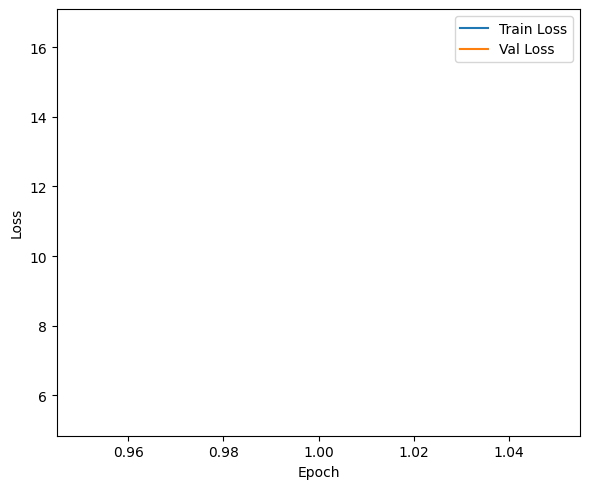

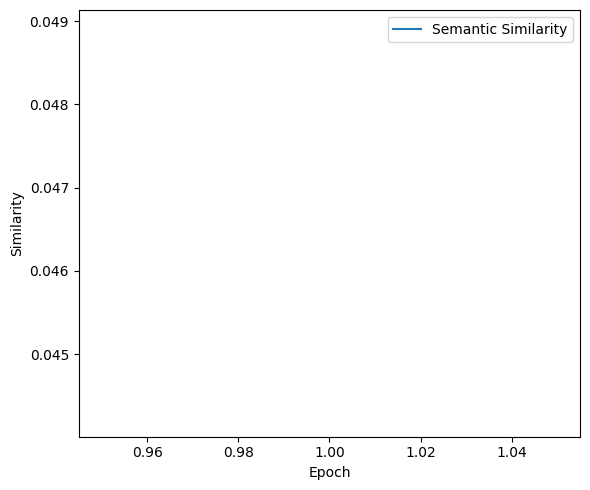


-- Phase 2, Epoch 1/1 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 5.3146
  Validation Loss     : 4.9402
  Semantic Similarity : 0.0466


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 4.9816
Test Semantic Similarity: 0.0556

--- Example 23 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality_x000D_
_x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality No bony abnormality
Generated Report : 
 

--- Example 97 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality.
Generated Report : 
 

--- Example 24 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
degenerative change.
Generated Report : 
 

--- Example 91 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality._x000D_
[ Diagnosis ]_x000D_
No bony abnormality._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality. No bony abnormality.
Generated

In [19]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions for data preparation
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Custom GPT-2 components
# =============================================================================
class CustomGPT2Config:
    def __init__(
        self,
        vocab_size: int = 50257,
        embed_dim: int = 768,
        num_heads: int = 12,
        mlp_ratio: int = 4,
        seq_len: int = 512,
        attention_dropout: float = 0.1,
        residual_dropout: float = 0.1,
        mlp_dropout: float = 0.1,
        num_layers: int = 12,
    ):
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.seq_len = seq_len
        self.attention_dropout = attention_dropout
        self.residual_dropout = residual_dropout
        self.mlp_dropout = mlp_dropout
        self.num_layers = num_layers

class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

    def forward(self, x):
        b, t, c = x.size()
        q, k, v = self.c_attn(x).chunk(3, -1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        att = (q @ k.transpose(-2, -1)) * self.scale
        att = att.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        att = F.softmax(att, -1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim // self.n_heads
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            nn.init.zeros_(m.bias)

    def forward(self, q, k, v):
        b, qt, _ = q.size()
        q_ = self.q(q).view(b, qt, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k_ = self.k(k).view(b, -1, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v_ = self.v(v).view(b, -1, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        att = (q_ @ k_.transpose(-2, -1)) * self.scale
        att = F.softmax(att, -1)
        att = self.attn_dropout(att)
        y = att @ v_
        y = y.permute(0, 2, 1, 3).contiguous().view(b, qt, self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embed_dim, config.embed_dim * config.mlp_ratio)
        self.act = nn.GELU()
        self.c_proj = nn.Linear(config.embed_dim * config.mlp_ratio, config.embed_dim)
        self.dropout = nn.Dropout(config.mlp_dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.cross = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(config.embed_dim)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class CustomGPT2Decoder(nn.Module):
    def __init__(self, config: CustomGPT2Config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.residual_dropout)
        self.h = nn.ModuleList([GPT2Block(config) for _ in range(config.num_layers)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        self.lm_head.weight = self.wte.weight

    def forward(
        self,
        input_ids,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
    ):
        b, t = input_ids.size()
        positions = torch.arange(t, device=input_ids.device).unsqueeze(0).expand(b, -1)
        x = self.wte(input_ids) + self.wpe(positions)
        x = self.drop(x)
        for block in self.h:
            x = block(x, encoder_hidden_states)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss(ignore_index=self.config.vocab_size - 1)
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
        return type("ModelOutput", (object,), {"loss": loss, "logits": logits})

    @torch.no_grad()
    def generate(
        self,
        input_ids,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        max_length: int = 150,
        eos_token_id: int = None,
        pad_token_id: int = None,
        **kwargs
    ):
        B, cur_len = input_ids.shape
        generated = input_ids
        for _ in range(max_length - cur_len):
            out = self.forward(
                generated,
                attention_mask=None,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
            )
            next_logits = out.logits[:, -1, :]
            next_token = next_logits.argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            if eos_token_id is not None and (next_token == eos_token_id).all():
                break
        return generated

    def get_input_embeddings(self):
        return self.wte

    def get_output_embeddings(self):
        return self.lm_head

# =============================================================================
# MultiModalModel with custom decoder (no LoRA)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, custom_gpt_config: CustomGPT2Config):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, custom_gpt_config.embed_dim)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, custom_gpt_config.embed_dim)

        self.attn = nn.MultiheadAttention(embed_dim=custom_gpt_config.embed_dim,
                                          num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(custom_gpt_config.embed_dim)

        self.decoder = CustomGPT2Decoder(custom_gpt_config)
        print("Custom GPT-2 decoder integrated (no LoRA)")

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B, N, C, H, W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled = pf_feats.mean(dim=[2,3])
        pf = self.patch_proj(pf_pooled).view(B, N, -1)

        cat, _ = self.attn(
            torch.cat([g, pf], 1),
            torch.cat([g, pf], 1),
            torch.cat([g, pf], 1)
        )
        comb = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            encoder_attention_mask=torch.ones(B, comb.size(1), device=comb.device),
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device, tokenizer):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = (model.patch_encoder.forward_features(p)
                        if hasattr(model.patch_encoder, 'forward_features')
                        else model.patch_encoder(p))
            pf_pooled= pf_feats.mean(dim=[2,3])
            pf        = model.patch_proj(pf_pooled).view(B, N, -1)
            cat,_  = model.attn(
                torch.cat([g,pf],1),
                torch.cat([g,pf],1),
                torch.cat([g,pf],1)
            )
            comb    = model.norm(cat)

            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(6,5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,5))
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch"); plt.ylabel("Similarity"); plt.legend(); plt.tight_layout(); plt.show()

# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    class Cfg: pass
    cfg = Cfg()
    cfg.DATASET = Cfg()
    cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
    cfg.DATASET.USE_RAW        = True
    cfg.DATASET.USE_PATCH      = True
    cfg.DATASET.REPORT         = True
    cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE        = False
    cfg.DATASET.AUGMENT        = False

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({
        "bos_token": "<BOS>",
        "additional_special_tokens": ["FINDINGS:"]
    })
    tokenizer.padding_side = 'left'
    tokenizer.pad_token     = tokenizer.eos_token
    globals()['tokenizer']  = tokenizer

    # Show class counts
    dataset = FinalSamplesDataset(cfg)
    dataset.tokenizer = tokenizer
    dataset.eos_token = tokenizer.eos_token

    dist = Counter(e['class_label'] for e in dataset.data.values())
    for cls, cnt in dist.items():
        logging.info(f"  {cls}: {cnt}")
        print(f"  {cls}: {cnt}")

    # Train/Val/Test split sizes
    n = len(dataset)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val
    print(f"\nNumber of training samples:   {n_train}")
    print(f"Number of validation samples: {n_val}")
    print(f"Number of test samples:       {n_test}")
    print(f"Total samples:                {n_train + n_val + n_test}\n")

    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

    # Model setup
    custom_cfg = CustomGPT2Config(
        vocab_size=len(tokenizer),
        embed_dim=768,
        num_heads=12,
        mlp_ratio=4,
        seq_len=512,
        attention_dropout=0.1,
        residual_dropout=0.1,
        mlp_dropout=0.1,
        num_layers=12,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = MultiModalModel(custom_cfg).to(device)

    # Phase 1
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    scaler    = torch.amp.GradScaler()
    train_losses, val_losses, sems = [], [], []

    for epoch in range(1):
        print(f"\n-- Phase 1, Epoch {epoch+1}/1 --")
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)

        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item()**2
        print(f"Grad norm after 1st epoch backward: {total_norm**0.5:.4f}")

        val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device, tokenizer)
        sem = compute_semantic_similarity(gen_txt, gt_txt)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        sems.append(sem)

        print(f"  Train Loss          : {train_loss:.4f}")
        print(f"  Validation Loss     : {val_loss:.4f}")
        print(f"  Semantic Similarity : {sem:.4f}")
        scheduler.step()

    plot_metrics(train_losses, val_losses, sems)

    # Phase 2
    optimizer = optim.AdamW(model.parameters(), lr=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
    scaler    = torch.amp.GradScaler()

    for epoch in range(1):
        print(f"\n-- Phase 2, Epoch {epoch+1}/1 --")
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device, tokenizer)
        sem = compute_semantic_similarity(gen_txt, gt_txt)

        print(f"  Train Loss          : {train_loss:.4f}")
        print(f"  Validation Loss     : {val_loss:.4f}")
        print(f"  Semantic Similarity : {sem:.4f}")
        scheduler.step()

    # Final test
    test_loss, test_gen, test_gt = evaluate(model, test_loader, device, tokenizer)
    test_sem = compute_semantic_similarity(test_gen, test_gt)

    print("\n========== TEST RESULTS ==========")
    print(f"Test Loss               : {test_loss:.4f}")
    print(f"Test Semantic Similarity: {test_sem:.4f}")

    # Random examples
    for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
        ex    = test_ds[idx]
        raw   = ex['raw_report']
        clean = ex['cleaned_report']
        fi    = ex['full_img'].unsqueeze(0).to(device)
        pa    = ex['patches'].unsqueeze(0).to(device)

        g_feats = model.global_encoder(fi)
        g       = model.global_proj(g_feats).unsqueeze(1)
        B,N,C,H,W = pa.shape
        p      = pa.view(B*N, C, H, W)
        pf_feats= (model.patch_encoder.forward_features(p)
                   if hasattr(model.patch_encoder, 'forward_features')
                   else model.patch_encoder(p))
        pf_pooled= pf_feats.mean(dim=[2,3])
        pf        = model.patch_proj(pf_pooled).view(B,N,-1)
        cat,_    = model.attn(torch.cat([g,pf],1),
                              torch.cat([g,pf],1),
                              torch.cat([g,pf],1))
        comb     = model.norm(cat)

        prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
        prompt_mask= torch.ones_like(prompt_ids, device=device)
        gen_ids = model.decoder.generate(
            input_ids=prompt_ids,
            encoder_hidden_states=comb,
            eos_token_id=tokenizer.eos_token_id
        )
        gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        print(f"\n--- Example {idx} ---")
        print(f"Raw Report       : \n{raw}")
        print(f"Cleaned Report   : \n{clean}")
        print(f"Generated Report : \n{gen}")


## New JSON

In [2]:
import os
import json
import logging
import random
from pathlib import Path
from types import SimpleNamespace
from collections import defaultdict

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

from timm import create_model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sentence_transformers import SentenceTransformer

# ─────────────────────────────────────────────────────────────
# Logging: INFO+ to training.log
# ─────────────────────────────────────────────────────────────
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# ─────────────────────────────────────────────────────────────
# prepare_data for binary tasks
# ─────────────────────────────────────────────────────────────
def count_labels(data, target_classes):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in data.values():
        lbl = entry.get('class_label','').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_data(data, target_classes, is_binary=False):
    if is_binary:
        class_counts, data_by_class = count_labels(data, target_classes)
        min_count = min(class_counts.values())
        combined = []
        for lbl in target_classes:
            combined += random.sample(data_by_class[lbl], min_count)
        return combined, class_counts, class_counts
    else:
        return list(data.values()), {}, {}

# ─────────────────────────────────────────────────────────────
# 1) FinalSamplesDataset (updated)
# ─────────────────────────────────────────────────────────────
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform, patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'cleaned_report': item.get('cleaned_report', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        clean = e.get('cleaned_report', '').strip()
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids: {input_ids.shape}, attention_mask: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     e['cleaned_report'],
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    arr = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst = extract(arr, kps_dict[side])
                        if side == 'left':  left = lst
                        else:               right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

# ─────────────────────────────────────────────────────────────
# 2) Transforms
# ─────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
patch_transform = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ─────────────────────────────────────────────────────────────
# 3) Collate fn
# ─────────────────────────────────────────────────────────────
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    patches = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in patches)
    padded = []
    for p in patches:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        padded.append(p)
    patches = torch.stack(padded, 0)

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]

    labels = []
    for i in ids:
        seq = i.tolist()
        shifted = seq[1:] + [-100]
        labels.append(torch.tensor(shifted, dtype=torch.long))

    input_ids = nn.utils.rnn.pad_sequence(ids, batch_first=True,
                                          padding_value=tokenizer.pad_token_id)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True,
                                               padding_value=0)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True,
                                       padding_value=-100)

    return imgs, patches, input_ids, attention_mask, labels

# ─────────────────────────────────────────────────────────────
# 4) VisionGPT2Model + submodules
# ─────────────────────────────────────────────────────────────
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        self.c_attn = nn.Linear(self.embed_dim, self.head_size*self.n_heads*3)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        self.c_proj= nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout= nn.Dropout(config.attention_dropout)
        self.resid_dropout= nn.Dropout(config.residual_dropout)

    def forward(self, x):
        b, t, c = x.size()
        q, k, v = self.c_attn(x).chunk(3, -1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0,2,1,3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0,2,1,3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0,2,1,3)
        att = (q @ k.transpose(-2,-1)) * self.scale
        att = att.masked_fill(self.mask[:,:,:t,:t]==0, float('-inf'))
        att = F.softmax(att, -1); att = self.attn_dropout(att)
        y = att @ v; y = y.permute(0,2,1,3).contiguous().view(b,t,c)
        return self.resid_dropout(self.c_proj(y))

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim, self.n_heads = config.embed_dim, config.num_heads
        self.head_size = self.embed_dim // self.n_heads
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            nn.init.zeros_(m.bias)

    def forward(self, q, k, v):
        b, qt, _ = q.size()
        q_ = self.q(q).view(b, qt, self.n_heads, self.head_size).permute(0,2,1,3)
        k_ = self.k(k).view(b, -1, self.n_heads, self.head_size).permute(0,2,1,3)
        v_ = self.v(v).view(b, -1, self.n_heads, self.head_size).permute(0,2,1,3)
        att = F.softmax((q_ @ k_.transpose(-2,-1)) * self.scale, -1)
        att = self.attn_dropout(att)
        y = att @ v_; y = y.permute(0,2,1,3).contiguous().view(b, qt, self.embed_dim)
        return self.resid_dropout(self.c_proj(y))

class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embed_dim, config.embed_dim * config.mlp_ratio)
        self.act  = nn.GELU()
        self.c_proj = nn.Linear(config.embed_dim * config.mlp_ratio, config.embed_dim)
        self.dropout = nn.Dropout(config.mlp_dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.cross = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(config.embed_dim)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross(self.ln_2(x), enc, enc)
        x = x + self.mlp(self.ln_3(x))
        return x

class VisionGPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.patch_embed = vit.patch_embed
        self.cls_token   = vit.cls_token
        self.pos_embed   = vit.pos_embed
        self.pos_drop    = nn.Dropout(0.)
        self.vit_blocks  = vit.blocks[:config.depth]

        self.config   = config
        self.wte      = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe      = nn.Embedding(config.seq_len,   config.embed_dim)
        self.drop     = nn.Dropout(config.emb_dropout)
        self.h        = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f     = nn.LayerNorm(config.embed_dim)
        self.lm_head  = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        self.lm_head.weight = self.wte.weight

    @classmethod
    def from_pretrained(cls, config):
        model = cls(config)
        hf = GPT2LMHeadModel.from_pretrained('gpt2').state_dict()
        sd = model.state_dict()
        for k, v in hf.items():
            if k in sd and sd[k].shape == v.shape:
                sd[k].copy_(v)
        model.load_state_dict(sd)
        return model

    def forward(self, image, input_ids, labels=None):
        x = self.patch_embed(image)
        x = torch.cat([self.cls_token.expand(x.size(0), -1, -1), x], 1)
        x = x + self.pos_embed; x = self.pos_drop(x)
        for blk in self.vit_blocks:
            x = blk(x)

        b, t = input_ids.size()
        tok = self.wte(input_ids)
        pos = torch.arange(t, device=input_ids.device).unsqueeze(0)
        pos = self.wpe(pos)
        h = self.drop(tok + pos)

        for blk in self.h:
            h = blk(h, x)
        h = self.ln_f(h)

        if labels is not None:
            lm_logits = self.lm_head(h)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.size(-1)),
                                   labels.view(-1))
            return loss
        else:
            return self.lm_head(h[:, -1, :])

    def generate(self, image, seq, max_tokens=50, temperature=1.0, deterministic=False):
        for _ in range(max_tokens):
            logits = self(image, seq) / temperature
            probs = F.softmax(logits, -1)
            if deterministic:
                nxt = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                nxt = torch.multinomial(probs, 1)
            seq = torch.cat([seq, nxt], 1)
            if nxt.item() == tokenizer.eos_token_id:
                break
        return seq

# ─────────────────────────────────────────────────────────────
# 5) Trainer
# ─────────────────────────────────────────────────────────────
class Trainer:
    def __init__(self, model_config, train_config, dls):
        self.device = train_config.device
        self.model  = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        for p in self.model.parameters():
            p.requires_grad = False
        self.model.h.requires_grad_(True)

        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.optim = torch.optim.Adam(self.model.parameters(), lr=train_config.lr)
        self.train_dl, self.val_dl = dls
        self.train_config = train_config

    def train_one_epoch(self):
        self.model.train()
        total = 0
        for imgs, patches, ids, mask, labels in tqdm(self.train_dl, desc="Train"):
            imgs, ids, labels = imgs.to(self.device), ids.to(self.device), labels.to(self.device)
            loss = self.model(imgs, ids, labels)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            total += loss.item()
        return total / len(self.train_dl)

    @torch.no_grad()
    def valid_one_epoch(self):
        self.model.eval()
        total = 0
        for imgs, patches, ids, mask, labels in tqdm(self.val_dl, desc="Val"):
            imgs, ids, labels = imgs.to(self.device), ids.to(self.device), labels.to(self.device)
            total += self.model(imgs, ids, labels).item()
        return total / len(self.val_dl)

    def fit(self):
        best = float('inf')
        os.makedirs(self.train_config.model_path, exist_ok=True)
        for ep in range(self.train_config.epochs):
            tl = self.train_one_epoch()
            vl = self.valid_one_epoch()
            print(f"Epoch {ep+1}/{self.train_config.epochs} — train {tl:.4f}, val {vl:.4f}")
            if vl < best:
                best = vl
                torch.save(self.model.state_dict(),
                           os.path.join(self.train_config.model_path, 'best.pt'))

    def generate_caption(self, image_path, temp=1.0, det=False):
        seq = torch.tensor([[self.tokenizer.bos_token_id]],
                           device=self.device)
        img = np.array(Image.open(image_path).convert('RGB'))
        img = train_transform(Image.fromarray(img)).unsqueeze(0).to(self.device)
        out = self.model.generate(img, seq, temperature=temp, deterministic=det)
        return self.tokenizer.decode(out[0].cpu(), skip_special_tokens=True)

# ─────────────────────────────────────────────────────────────
# 6) Main
# ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    model_config = SimpleNamespace(
        vocab_size=50257, embed_dim=768, num_heads=12,
        seq_len=512, depth=12,
        attention_dropout=0.1, residual_dropout=0.1,
        mlp_ratio=4, mlp_dropout=0.1, emb_dropout=0.1
    )
    train_config = SimpleNamespace(
        epochs=5,
        lr=1e-4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_path='captioner'
    )

    # Tokenizer for collate_fn
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    cfg = SimpleNamespace()
    cfg.DATASET = SimpleNamespace()
    cfg.DATASET.JSON = 'final_samples_both_only_v2_cleaned.json'
    cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
    cfg.DATASET.BALANCE = False
    cfg.DATASET.AUGMENT = False

    ds = FinalSamplesDataset(cfg,
                             image_transform=train_transform,
                             patch_transform=patch_transform)
    ds.tokenizer = tokenizer
    ds.eos_token = tokenizer.eos_token

    n = len(ds)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val

    train_ds, val_ds, test_ds = random_split(
        ds, [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42)
    )

    train_dl = DataLoader(train_ds, batch_size=8, shuffle=True,
                          collate_fn=collate_fn, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=8, shuffle=False,
                          collate_fn=collate_fn, pin_memory=True)

    trainer = Trainer(model_config, train_config, (train_dl, val_dl))
    trainer.fit()

    # ─────────────────────────────────────────────────────────
    # 7) Sample 20 random examples from test set + compute semantic sim
    # ─────────────────────────────────────────────────────────
    print("\n=== 10 Random Test Examples ===\n")
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    random.seed(42)
    sample_idxs = random.sample(range(len(test_ds)), min(20, len(test_ds)))
    sims = []
    for idx in sample_idxs:
        orig_idx = test_ds.indices[idx]
        item = test_ds[idx]
        actual = item['cleaned_report']
        img_path = ds.data[orig_idx]['file_path']
        generated = trainer.generate_caption(img_path, temp=1.0, det=False)
        emb_actual = stm.encode(actual, convert_to_tensor=True)
        emb_gen    = stm.encode(generated, convert_to_tensor=True)
        sim = F.cosine_similarity(emb_actual, emb_gen, dim=0).item()
        sims.append(sim)
        print(f"--- Example {idx} (orig #{orig_idx}) ---")
        print(f"Actual cleaned report : {actual}")
        print(f"Generated report      : {generated}")
        print(f"Semantic similarity   : {sim:.4f}\n")

    # ─────────────────────────────────────────────────────────
    # 8) Overall semantic similarity
    # ─────────────────────────────────────────────────────────
    overall_sim = sum(sims) / len(sims) if sims else 0.0
    print(f"Overall average semantic similarity over {len(sims)} examples: {overall_sim:.4f}")


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/5 — train 4.6618, val 3.6917


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/5 — train 3.4451, val 2.9861


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/5 — train 2.8612, val 2.5721


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/5 — train 2.5022, val 2.3614


Train:   0%|          | 0/240 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/5 — train 2.2294, val 2.2444

=== 10 Random Test Examples ===



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 163 (orig #399) ---
Actual cleaned report : The patient presents with rheumatoid arthritis affecting both hands and feet with erosions and bone changes, suggesting a possible RA diagnosis.
Generated report      :  FINDINGS: The report indicates a degenerative change and recommending further investigation and potential treatment. 
Semantic similarity   : 0.3145



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 28 (orig #1421) ---
Actual cleaned report : The patient has narrowing joint space in the left big toe, suggestive of gout arthritis.
Generated report      :  FINDINGS: The patient has a mild osteopenia in small calcoarthritis with lout, and a elite discussion; bone swelling swelling osteo point may resting malohydrate on ankle swelling swelling on soft tissue swelling in with probableus.
Semantic similarity   : 0.4632



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 6 (orig #438) ---
Actual cleaned report : No significant bony abnormality, therefore, no significant bony abnormality, and no specific recommendation.
Generated report      :  FINDINGS: The suspicious indicates a degenerative change and recommends further investigation and potential treatment. 
Semantic similarity   : 0.3631



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 189 (orig #1485) ---
Actual cleaned report : The report indicates a degenerative change with a conclusion recommending further investigation.
Generated report      :  FINDINGS: No bony lesion; no findings of concern, 
Semantic similarity   : 0.3482



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 70 (orig #1203) ---
Actual cleaned report : No significant bony lesion was detected on radiographs, and no diagnosis is required.
Generated report      :  FINDINGS: The patient has mild osteopenia in degenerative changes on both feet of suggests. 
Semantic similarity   : 0.3143



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 62 (orig #2249) ---
Actual cleaned report : The report indicates a degenerative change, with a conclusion suggesting further investigation is needed, and a recommendation for monitoring.
Generated report      :  FINDINGS: The patient has degenerative changes and, degenerative changes on under cause such rheumatoid arthritis coalition repair, and tPT joint, and degenerative change and calcophyte involving and requiring further investigation. 
Semantic similarity   : 0.5255



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 57 (orig #727) ---
Actual cleaned report : No bony abnormalities are present, and the patient is diagnosed with no bony abnormalities.
Generated report      :  FINDINGS: The patient has [ degenerative change, degenerative exceeding mal vibration bone swelling fracture and supp nav centre and degenerative change, requiring further investigation and lower management. 
Semantic similarity   : 0.4173



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 35 (orig #2192) ---
Actual cleaned report : The report indicates a degenerative change, recommending further evaluation and potential treatment.
Generated report      :  FINDINGS: No bony abnormalities detected, no findings of concern, 
Semantic similarity   : 0.3415



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 188 (orig #1000) ---
Actual cleaned report : No bony abnormality, requiring no further action.
Generated report      :  FINDINGS: No bony abnormalitiesality found found no abnormalitiesality, 
Semantic similarity   : 0.7842



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 26 (orig #1286) ---
Actual cleaned report : The patient has ankle osteoarthritis and knee osteoarthritis, with specific findings including a fractured first metatarsophalangeal joint (R/O gout) and a right first metatarsophalangeal joint (R/O gout).
Generated report      :  FINDINGS: No bony abnormality, no findings of no no recommendations further evaluation. 
Semantic similarity   : 0.3465



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 173 (orig #923) ---
Actual cleaned report : The patient has subtle osteophyte, a lesion, and a suspicious subchondral cyst, potentially indicating a subchondral fracture.
Generated report      :  FINDINGS: No bony abnormality, no findings of concern, no findings is no recommendations. 
Semantic similarity   : 0.3320



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 228 (orig #113) ---
Actual cleaned report : The report indicates a degenerative change with a conclusion recommending further investigation.
Generated report      :  FINDINGS: The patient has no diagnosis of osteopenia in both knees chronic and osteopenia and brhesakoid joint and pointing spot and and calcteart on both knees, and pesane arthritisopenia and and with joint at
Semantic similarity   : 0.2424



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 139 (orig #1120) ---
Actual cleaned report : The patient has a degenerative change and osteopenia, requiring further investigation and management.
Generated report      :  FINDINGS: The Tib eff swelling in degenerative change requiring further evaluation and potential further investigation. 
Semantic similarity   : 0.4850



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 22 (orig #514) ---
Actual cleaned report : Mild degenerative change requires monitoring and ongoing assessment.
Generated report      :  FINDINGS: The patient has soft tissue swelling and degenerative changes, requiring further investigation. 
Semantic similarity   : 0.4407



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 151 (orig #217) ---
Actual cleaned report : The patient was diagnosed with a Lt. 1st toe and recommended corrective osteotomy.
Generated report      :  FINDINGS: The report indicates a degenerative change, requiring further evaluation and potential treatment. 
Semantic similarity   : 0.3744



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 108 (orig #732) ---
Actual cleaned report : The patient has hallux valgus on the right foot, with possible osteoarthritis in both first and second metatarsophalangeal joints, and osteophyte in the talus neck.
Generated report      :  FINDINGS: No bony abnormalities are present; no diagnosis is required and recommended further investigation. 
Semantic similarity   : 0.4264



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 8 (orig #814) ---
Actual cleaned report : No bony abnormalities detected, resulting in a diagnosis of [Diagnosis] and recommending [Recommend].
Generated report      :  FINDINGS: No bony abnormalitiesality, no no diagnosis of recommended further investigation. 
Semantic similarity   : 0.8074



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 7 (orig #2219) ---
Actual cleaned report : No significant interval change, therefore, no significant interval change, and no further recommendations are needed.
Generated report      :  FINDINGS: Both degenerative change requires ongoing monitoring. 
Semantic similarity   : 0.2123



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 23 (orig #1698) ---
Actual cleaned report : The patient has R/O gout on both feet.
Generated report      :  FINDINGS: The patient has degenerative changes and degenerative changes, specifically further investigation. 
Semantic similarity   : 0.2302



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

--- Example 55 (orig #480) ---
Actual cleaned report : Mild soft tissue swelling of the right lateral ankle is indicated.
Generated report      :  FINDINGS: The patient has gout disordery on with left first metatarsophophalangealangealangealangeange head both rout in soft tissue swelling. 
Semantic similarity   : 0.4475

Overall average semantic similarity over 20 examples: 0.4108
